# Intro

In [28]:
import os
import os.path as op

import numpy as np
import scipy as sp
import pandas as pd
import sqlalchemy as sa

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)

from common import dat

In [29]:
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
sns.set_context('notebook', font_scale=2)
sns.set_style('whitegrid')

# Load data

In [32]:
ch1_train_combination_and_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_train_combination_and_monotherapy.csv/'
    'ch1_train_combination_and_monoTherapy.csv', sep=','
)
display(ch1_train_combination_and_monotherapy.head())

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-20,ADAM17,AKT,1,75,1.000000,0.809002,59.122436,9.639714,0.757977,91.593425,29.540390,1,ADAM17.AKT
1,CAL-120,ADAM17,AKT,1,75,0.183214,2.503678,60.411999,1.000000,0.000000,100.000000,4.401410,-1,ADAM17.AKT
2,CAL-51,ADAM17,AKT,1,75,1.000000,0.726984,11.150843,75.000000,0.375043,76.656479,0.315422,1,ADAM17.AKT
3,DU-4475,ADAM17,AKT,1,75,0.321533,10.000000,58.599487,75.000000,1.995866,6.171007,-41.734090,-1,ADAM17.AKT
4,HCC1143,ADAM17,AKT,1,75,0.398673,10.000000,89.098894,1.000000,0.000000,100.000000,35.532770,-1,ADAM17.AKT


In [33]:
# Print some statistics
ch_1_compounds = (
    set(ch1_train_combination_and_monotherapy['COMPOUND_A']) |
    set(ch1_train_combination_and_monotherapy['COMPOUND_B'])
)
dat.print2('Number of rows:', len(ch1_train_combination_and_monotherapy))
dat.print2('Number of cell lines:', len(set(ch1_train_combination_and_monotherapy['CELL_LINE'])))
dat.print2('Number of compoounds:', len(ch_1_compounds))
dat.print2('Number of combinations:', len(set(ch1_train_combination_and_monotherapy['COMBINATION_ID'])))

Number of rows:                                             2199
Number of cell lines:                                       85
Number of compoounds:                                       69
Number of combinations:                                     169


In [34]:
combinations_df_1 = ch1_train_combination_and_monotherapy.copy()

In [35]:
def get_weight(QA):
    if QA == 1:
        return 1
    elif QA == -1:
        return 0.1
    elif QA == -2:
        return 0.05
    elif QA == -3:
        return 0.01
    else:
        raise Exception()

combinations_df_1['WEIGHT'] = combinations_df_1['QA'].apply(get_weight)

# Group by combination id

In [36]:
from functions import *
df = get_weighted_stats(combinations_df_1, 'COMBINATION_ID', 'SYNERGY_SCORE', 'WEIGHT')

In [37]:
df.head()

,COMBINATION_ID,len,mean,mean_unweighted,std,std_unweighted,sum_weight,ste,log_ste,norm_log_ste,confidence
0,ADAM17.AKT,14,9.187210,5.005206,18.523353,23.066728,10.40,4.950574,1.599504,0.361350,0.638650
1,ADAM17.BCL2_BCL2L1,12,-3.503092,-4.554570,5.611126,6.539051,11.10,1.619792,0.482298,0.004350,0.995650
2,ADAM17.FGFR,13,-5.198812,-8.917044,17.691588,20.848170,10.30,4.906764,1.590615,0.358510,0.641490
3,ADAM17.MAP2K_1,13,-1.926945,-6.053760,16.215875,18.690474,11.20,4.497474,1.503516,0.330678,0.669322
4,ADAM17.MTOR_1,14,9.439891,9.625085,17.336281,15.960108,10.31,4.633316,1.533273,0.340186,0.659814


/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


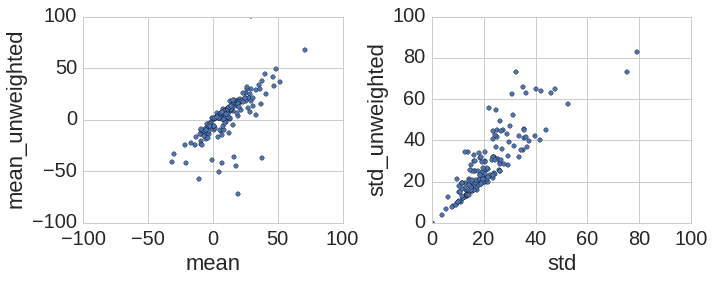

In [38]:
# Compare weighted and unweighted values
fg, ax = plt.subplots(1, 2, figsize=(10, 4))
df.plot(x='mean', y='mean_unweighted', kind='scatter', ax=ax[0])
ax[0].set_xlim(-100, 100)
ax[0].set_ylim(-100, 100)
df.plot(x='std', y='std_unweighted', kind='scatter', ax=ax[1])
ax[1].set_xlim(0, 100)
ax[1].set_ylim(0, 100)
plt.tight_layout()

Overall weighed values have about the same mean and a smaller standard deviation than unweighted values, as expected. The stats appear OK.

## Result

In [39]:
group_by_combination = (
    df[['COMBINATION_ID', 'mean', 'confidence']]
    .rename(columns={
        'mean': 'combination_synergy_score',
        'confidence': 'combination_synergy_confidence',
    })
)

# Group by cell line

In [40]:
from functions import *
df = get_weighted_stats(combinations_df_1, 'CELL_LINE', 'SYNERGY_SCORE', 'WEIGHT')

In [41]:
df.head()

,CELL_LINE,len,mean,mean_unweighted,std,std_unweighted,sum_weight,ste,log_ste,norm_log_ste,confidence
0,22RV1,2,-8.601674,-8.601674,5.217406,5.217406,2.00,3.689263,1.305427,0.280860,0.719140
1,647-V,23,13.834063,13.834063,24.923975,24.923975,23.00,5.197008,1.648083,0.396230,0.603770
2,A549,20,24.890324,21.671942,35.834833,34.170838,16.12,8.012912,2.081054,0.542008,0.457992
3,BFTC-905,25,21.839952,21.839952,33.543954,33.543954,25.00,6.708791,1.903419,0.482199,0.517801
4,BT-20,51,22.283808,22.283808,20.415080,20.415080,51.00,2.858683,1.050361,0.194981,0.805019


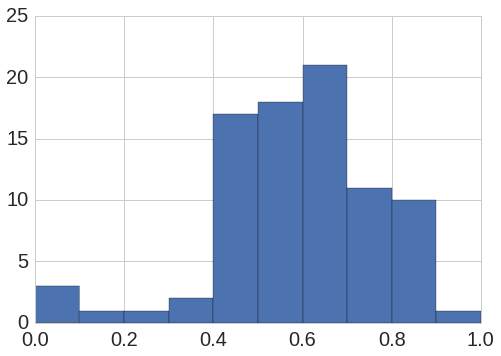

In [42]:
df['confidence'].hist()

## Result

In [43]:
group_by_cell_line = (
    df[['CELL_LINE', 'mean', 'confidence']]
    .rename(columns={
        'mean': 'cell_line_synergy_score',
        'confidence': 'cell_line_synergy_confidence',
    })
)

# Machine learning

In [68]:
combinations_df_1b = (
    combinations_df_1
    .merge(group_by_combination, on=['COMBINATION_ID'])
    .merge(group_by_cell_line, on=['CELL_LINE'])
)

In [69]:
combinations_df_1b['MAX_CONC_diff'] = abs(combinations_df_1b['MAX_CONC_A'] - combinations_df_1b['MAX_CONC_B'])
combinations_df_1b['IC50_diff'] = abs(combinations_df_1b['IC50_A'] - combinations_df_1b['IC50_B'])
combinations_df_1b['H_diff'] = abs(combinations_df_1b['H_A'] - combinations_df_1b['H_B'])
combinations_df_1b['Einf_diff'] = abs(combinations_df_1b['Einf_A'] - combinations_df_1b['Einf_B'])

In [70]:
combinations_df_1b.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID,WEIGHT,combination_synergy_score,combination_synergy_confidence,cell_line_synergy_score,cell_line_synergy_confidence,MAX_CONC_diff,IC50_diff,H_diff,Einf_diff
0,BT-20,ADAM17,AKT,1.0,75,1.000000,0.809002,59.122436,9.639714,0.757977,91.593425,29.54039,1,ADAM17.AKT,1,9.187210,0.638650,22.283808,0.805019,74.0,8.639714,0.051025,32.470988
1,BT-20,ADAM17,MTOR_1,1.0,75,0.605688,1.265459,0.000000,75.000000,0.847787,68.226821,18.30981,1,ADAM17.MTOR_1,1,9.439891,0.659814,22.283808,0.805019,74.0,74.394312,0.417672,68.226821
2,BT-20,AKT,AKT_1,1.0,1,0.258830,2.652293,63.932989,0.457555,1.962639,80.811860,20.26494,1,AKT.AKT_1,1,4.640847,0.830387,22.283808,0.805019,0.0,0.198726,0.689654,16.878872
3,BT-20,AKT,CSNK2A1_2,0.1,3,0.011525,1.806654,5.735584,1.367930,0.982129,0.000000,11.97265,1,AKT.CSNK2A1_2,1,29.285410,0.598130,22.283808,0.805019,2.9,1.356405,0.824525,5.735584
4,BT-20,AKT,Chloroquine,3.0,3,1.066453,10.000000,79.099316,0.352249,1.282071,22.807083,18.41805,1,AKT.Chloroquine,1,7.343404,0.700970,22.283808,0.805019,0.0,0.714204,8.717929,56.292233


## Features

In [121]:
FEATURES = [
    'combination_synergy_score', 'combination_synergy_confidence', 
    'cell_line_synergy_score', 'cell_line_synergy_confidence',
    'MAX_CONC_diff', 'IC50_diff', 'H_diff', 'Einf_diff',
]

In [122]:
combinations_df_1b[combinations_df_1b[FEATURES].isnull().any(axis=1)]

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID,WEIGHT,combination_synergy_score,combination_synergy_confidence,cell_line_synergy_score,cell_line_synergy_confidence,MAX_CONC_diff,IC50_diff,H_diff,Einf_diff


In [123]:
FEATURES

['combination_synergy_score',
 'combination_synergy_confidence',
 'cell_line_synergy_score',
 'cell_line_synergy_confidence',
 'MAX_CONC_diff',
 'IC50_diff',
 'H_diff',
 'Einf_diff']

## Train a predictor

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


In [60]:
clf_options = {
    'loss': 'ls',
    'n_estimators': 900,
    'learning_rate': 0.01,
    'max_depth': 2,
    'subsample': 0.3,
    'random_state': np.random.RandomState(42)
}
clf = GradientBoostingRegressor(**clf_options)

In [62]:
from functions import * 
cross_validate(clf, combinations_df_1b, FEATURES, 'SYNERGY_SCORE')

Cross validating MTOR_1.PIK3CA_4...
Cross validating BCL2L1.IAP...
Cross validating HSP90.PARP1...
Cross validating PARP1.PIK3CB_PIK3CD...
Cross validating ALK.PIK3C...
Cross validating ALK_IGFR.MTOR_1...
Cross validating PIM1.TOP2_2...
Cross validating BCL2L1.PIK3C...
Cross validating IGFR_4.MAP2K_1...
Cross validating BCL2_2.Vinorelbine...
Cross validating BRAF_M2.MAP2K_3...
Cross validating EG5.PIM1...
Cross validating AKT.PIP5K1...
Cross validating AKT.CSNK2A1_2...
Cross validating IAP.PIK3C...
Cross validating ATR_4.CarboTaxol...
Cross validating ALK_2.MTOR_1...
Cross validating HDAC_4.PARP1...
Cross validating IAP.Oxaliplatin...
Cross validating BCL2_BCL2L1.PIM1...
Cross validating BCL2.CarboTaxol...
Cross validating AKT.ALK_IGFR...
Cross validating BCL2L1.Vinorelbine...
Cross validating BRAF_M.MAP2K_1...
Cross validating ERBB.Gemcitabine...
Cross validating FGFR.MTOR_3...
Cross validating ERBB.IAP...
Cross validating FASN.MTOR_1...
Cross validating IAP.Topotecan...
Cross validat

## Run gridsearch


In [101]:
grid_params = {
    'loss': ['ls'],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.5],
    'n_estimators': [50, 100, 200, 400, 600, 900],
    'max_depth': [2, 3, 4],
    'subsample': [0.1, 0.2, 0.4, 0.6, 0.8],
}

In [107]:
clf_options_list = []
for loss in grid_params['loss']:
    for learning_rate in grid_params['learning_rate']:
        for n_estimators in grid_params['n_estimators']:
            for max_depth in grid_params['max_depth']:
                for subsample in grid_params['subsample']:
                    clf_options = dict(
                        loss=loss,
                        learning_rate=learning_rate,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        subsample=subsample,
                    )
                    clf_options_list.append(clf_options)

### Submit jobs

In [160]:
output_dir = '/home/kimlab1/strokach/tmp/dream_challenge/cross_validation_2'
os.makedirs(output_dir, exist_ok=True)

In [125]:
import json
with open(op.join(output_dir, 'clf_options_list.json'), 'w') as ofh:
    json.dump(clf_options_list, ofh)

In [126]:
from functions import * 
for i, clf_options in enumerate(clf_options_list):
    cv = CrossValidate(clf_options, df, FEATURES, 'SYNERGY_SCORE')
    with open(op.join(output_dir, '{}.pickle'.format(i)), 'wb') as ofh:
        pickle.dump(cv, ofh)


Use the following bash command to submit jobs:

    for i in /home/kimlab1/strokach/tmp/dream_challenge/cross_validation_2/*; do echo $i; submitjob 1 -m 3 python -c "import pickle; cv = pickle.load(open('$i', 'rb')); cv.run(); cv.save('${i}.done');"; done
    
But remember that it must be run from inside the `drug_combinations` folder!

### Load results

In [165]:
correlations = []
for i, clf_options in enumerate(clf_options_list):
    y_pred = pd.read_pickle(op.join(output_dir, '{}.pickle.done'.format(i)))
    correlation = np.corrcoef([y_pred, df['SYNERGY_SCORE']])[0,1]
    correlations.append((i, clf_options, correlation))

In [166]:
correlations.sort(key=lambda x: x[2], reverse=True)

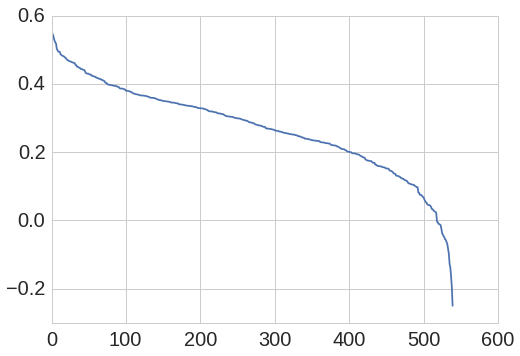

In [167]:
plt.plot(list(zip(*correlations))[2])

In [168]:
correlations[0]

(114,
 {'learning_rate': 0.01,
  'loss': 'ls',
  'max_depth': 3,
  'n_estimators': 100,
  'subsample': 0.8},
 0.57574667155228754,
 0         6.824927
 1         6.211651
 2         4.848582
 3        20.572769
 4         4.957589
 5        19.286816
 6        19.286816
 7         4.304111
 8         2.798298
 9         8.071645
 10        2.842902
 11       11.252594
 12        7.661728
 13       11.928192
 14        2.245157
 15        4.958297
 16        3.844757
 17        3.386249
 18       20.685751
 19       11.527191
 20       20.072951
 21        6.004636
 22       14.051128
 23        3.077934
 24        3.422230
 25       10.908544
 26       20.909722
 27       20.888981
 28       10.165994
 29       10.165994
 30        2.279060
 31        2.625989
 32       19.345452
 33       18.884684
 34        4.797807
 35       10.542147
 36       10.542147
 37       21.766947
 38       21.766947
 39        8.482173
 40        8.482173
 41        8.211875
 42       12.602760
 43      

## Train final predictors

In [256]:
idx_1 = 452
y_pred_1 = pd.read_pickle(
    '/home/kimlab1/strokach/tmp/dream_challenge/cross_validation_1/{}.pickle.done'.format(idx_1))
clf_options_1 = {
    'learning_rate': 0.5,
    'loss': 'ls',
    'max_depth': 2,
    'n_estimators': 50,
    'subsample': 0.4
}

In [257]:
features_1 = [
    'combination_synergy_score', 'combination_synergy_confidence', 
    'cell_line_synergy_score', 'cell_line_synergy_confidence',
    'MAX_CONC_diff', 'IC50_diff', 'H_diff', 'Einf_diff',
]

In [258]:
clf_1 = GradientBoostingRegressor(**clf_options_1)
clf_1.fit(combinations_df_1b[features_1], combinations_df_1b['SYNERGY_SCORE'])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.5, loss='ls',
             max_depth=2, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=None, subsample=0.4, verbose=0, warm_start=False)

In [259]:
df_1 = combinations_df_1b.copy()
df_1['prediction'] = y_pred_1
df_1_confidence = (
    df_1.groupby('COMBINATION_ID')
    .apply(lambda x: np.corrcoef(x['SYNERGY_SCORE'], x['prediction'])[0,1])
)
df_1_confidence[df_1_confidence < 0] = 0
df_1_confidence[pd.isnull(df_1_confidence)] = 0.1
assert not df_1_confidence.isnull().any()

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2079: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


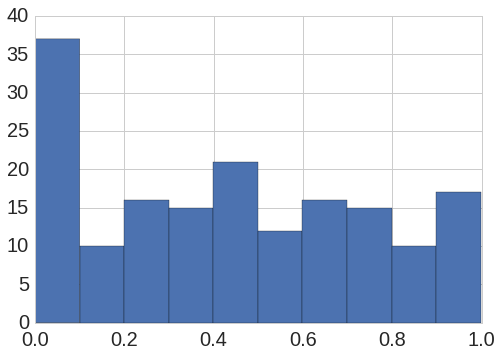

In [260]:
df_1_confidence.hist()

In [261]:
df_1_len = (
    df_1.groupby('COMBINATION_ID')['SYNERGY_SCORE'].agg(len)
)


In [262]:
idx_2 = 114
y_pred_2 = pd.read_pickle(
    '/home/kimlab1/strokach/tmp/dream_challenge/cross_validation_1/{}.pickle.done'.format(idx_2))
clf_options_2 = {
    'learning_rate': 0.01,
    'loss': 'ls',
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.8
}

In [263]:
features_2 = [
    'combination_synergy_score', 'combination_synergy_confidence', 
    'cell_line_synergy_score', 'cell_line_synergy_confidence',
]

In [264]:
clf_2 = GradientBoostingRegressor(**clf_options_2)
clf_2.fit(combinations_df_1b[features_2], combinations_df_1b['SYNERGY_SCORE'])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [265]:
df_2 = combinations_df_1b.copy()
df_2['prediction'] = y_pred_2
df_2_confidence = (
    df_2.groupby('COMBINATION_ID')
    .apply(lambda x: np.corrcoef(x['SYNERGY_SCORE'], x['prediction'])[0,1])
)
df_2_confidence[df_2_confidence < 0] = 0
df_2_confidence[pd.isnull(df_2_confidence)] = 0.1
assert not df_2_confidence.isnull().any()

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2079: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


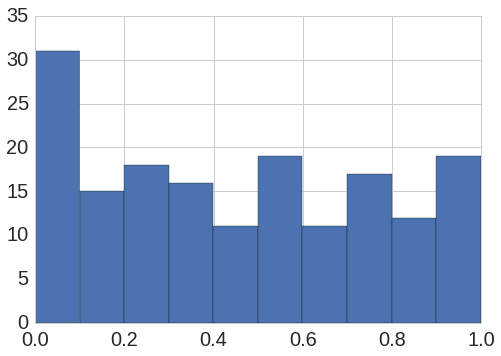

In [266]:
df_2_confidence.hist()

# Leaderboard

In [267]:
ch1_leaderboard_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_leaderboard_monotherapy.csv/'
    'ch1_leaderBoard_monoTherapy.csv', sep=','
)

In [268]:
ch1_leaderboard_monotherapy.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-549,ADAM17,AKT,1,75,0.184408,1.737511,59.575233,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
1,CAL-148,ADAM17,AKT,1,75,0.153391,1.754123,1.100779,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
2,HCC38,ADAM17,AKT,1,75,1.000000,10.000000,64.400080,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
3,BT-20,ADAM17,BCL2_BCL2L1,1,75,1.000000,1.161732,39.164587,75.0000,0.965792,70.915033,NaN,1,ADAM17.BCL2_BCL2L1
4,HCC1143,ADAM17,BCL2_BCL2L1,1,75,0.115309,10.000000,57.198795,0.0075,0.100000,80.128089,NaN,1,ADAM17.BCL2_BCL2L1


In [269]:
prediction = (
    ch1_leaderboard_monotherapy
    .merge(group_by_combination, on=['COMBINATION_ID'])
    .merge(group_by_cell_line, on=['CELL_LINE'])
)
prediction['MAX_CONC_diff'] = abs(prediction['MAX_CONC_A'] - prediction['MAX_CONC_B'])
prediction['IC50_diff'] = abs(prediction['IC50_A'] - prediction['IC50_B'])
prediction['H_diff'] = abs(prediction['H_A'] - prediction['H_B'])
prediction['Einf_diff'] = abs(prediction['Einf_A'] - prediction['Einf_B'])

In [270]:
prediction.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID,combination_synergy_score,combination_synergy_confidence,cell_line_synergy_score,cell_line_synergy_confidence,MAX_CONC_diff,IC50_diff,H_diff,Einf_diff
0,BT-549,ADAM17,AKT,1,75,0.184408,1.737511,59.575233,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT,9.187210,0.638650,3.051381,0.809608,74,0.815592,1.737511,40.424767
1,BT-549,ADAM17,MTOR_1,1,75,0.282911,1.614275,26.672166,1.0000,0.000000,100.000000,NaN,1,ADAM17.MTOR_1,9.439891,0.659814,3.051381,0.809608,74,0.717089,1.614275,73.327834
2,BT-549,ADAM17,PIK3C,1,75,0.314091,4.159118,39.212207,1.0000,0.000000,100.000000,NaN,1,ADAM17.PIK3C,15.446524,0.667204,3.051381,0.809608,74,0.685909,4.159118,60.787793
3,BT-549,ADAM17,PIK3CB_PIK3CD,1,75,0.566041,0.449959,0.000000,0.0075,0.100000,93.239189,NaN,1,ADAM17.PIK3CB_PIK3CD,7.724352,0.674561,3.051381,0.809608,74,0.558541,0.349959,93.239189
4,BT-549,AKT_SGK,FGFR,1,1,0.157868,0.999416,58.847437,1.0000,0.536471,2.478880,NaN,1,AKT_SGK.FGFR,0.847360,0.503123,3.051381,0.809608,0,0.842132,0.462945,56.368557


In [271]:
prediction['prediction_1'] = clf_1.predict(prediction[features_1])
prediction['prediction_2'] = clf_2.predict(prediction[features_2])

In [281]:
prediction_confidence = prediction[['COMBINATION_ID']].copy().drop_duplicates()
prediction_confidence['confidence_1'] = (
    prediction_confidence['COMBINATION_ID']
    .map(dict(df_1_confidence))
)
prediction_confidence['confidence_2'] = (
    prediction_confidence['COMBINATION_ID']
    .map(dict(df_2_confidence))
)

## Save results

In [277]:
(prediction
 .rename(columns={'prediction_1': 'PREDICTION'})
 [['CELL_LINE', 'COMBINATION_ID', 'PREDICTION']]
 .to_csv(
    '/home/kimlab1/strokach/working/drug_combinations/dream_challenge/output/subchallenge_1a.sub3/'
    'prediction.csv',
    index=False, quoting=2))

In [278]:
(prediction
 .rename(columns={'prediction_2': 'PREDICTION'})
 [['CELL_LINE', 'COMBINATION_ID', 'PREDICTION']]
 .to_csv(
    '/home/kimlab1/strokach/working/drug_combinations/dream_challenge/output/subchallenge_1b.sub3/'
    'prediction.csv',
    index=False, quoting=2))

In [282]:
(prediction_confidence
 .rename(columns={'confidence_1': 'CONFIDENCE'})
 [['COMBINATION_ID', 'CONFIDENCE']]
 .to_csv(
    '/home/kimlab1/strokach/working/drug_combinations/dream_challenge/output/subchallenge_1a.sub3/'
    'combination_priority.csv',
    index=False, quoting=2))

In [283]:
(prediction_confidence
 .rename(columns={'confidence_2': 'CONFIDENCE'})
 [['COMBINATION_ID', 'CONFIDENCE']]
 .to_csv(
    '/home/kimlab1/strokach/working/drug_combinations/dream_challenge/output/subchallenge_1b.sub3/'
    'combination_priority.csv',
    index=False, quoting=2))

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


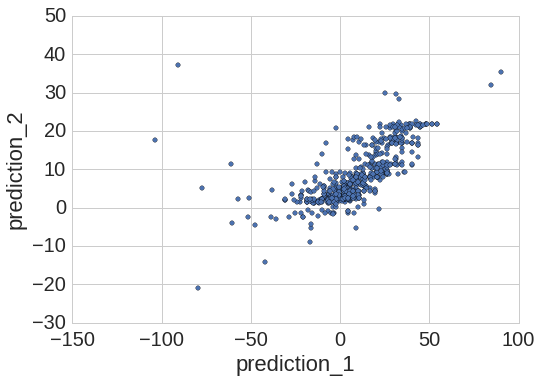

In [276]:
prediction.plot(x='prediction_1', y='prediction_2', kind='scatter')

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


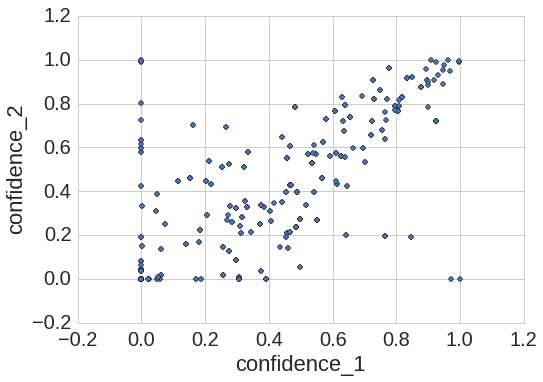

In [274]:
prediction_confidence.plot(x='confidence_1', y='confidence_2', kind='scatter')

## Submission 2

In [242]:
OUTPUT_FOLDER = 'output/subchallenge_1a.sub3'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

### prediction

In [ ]:
prediction['MAX_CONC_diff'] = abs(prediction['MAX_CONC_A'] - prediction['MAX_CONC_B'])
prediction['IC50_diff'] = abs(prediction['IC50_A'] - prediction['IC50_B'])
prediction['H_diff'] = abs(prediction['H_A'] - prediction['H_B'])
prediction['Einf_diff'] = abs(prediction['Einf_A'] - prediction['Einf_B'])

In [ ]:
prediction_3 = (
    prediction
    .merge(
        combinations_df_2b[['CELL_LINE', 'mean', 'ste']]
        .rename(columns={'mean': 'synergy_score_diff_mean', 'ste': 'synergy_score_diff_ste'}),
        on=['CELL_LINE'], how='left')
)
#prediction_3.loc[prediction_3['synergy_score_diff_mean'].isnull(),'synergy_score_diff_mean'] = prediction_3['synergy_score_diff_mean'].mean()
#prediction_3.loc[prediction_3['synergy_score_diff_ste'].isnull(),'synergy_score_diff_ste'] = prediction_3['synergy_score_diff_ste'].mean()

In [ ]:
prediction_3[prediction_3[FEATURES].isnull().any(axis=1)]

In [ ]:
prediction_3[prediction_3['COMBINATION_ID'] == 'HSP90.MAP2K_1']

In [ ]:
combinations_df_2b[combinations_df_2b['CELL_LINE'] == 'MDA-MB-175-VII']

In [ ]:
X = prediction_3[
    ['synergy_score_mean', 'synergy_score_diff_mean', 'synergy_score_diff_ste',
     #'MAX_CONC_diff', 'IC50_diff', 'H_diff', 'Einf_diff',
    ]
]

In [ ]:
y = prediction_3['SYNERGY_SCORE'].values

In [ ]:
X[X.isnull().any(axis=1)]

In [ ]:
y = clf.predict(X)

In [ ]:
prediction_3['PREDICTION'] = y

In [ ]:
prediction_3[["CELL_LINE","COMBINATION_ID","PREDICTION"]].to_csv(
    op.join(OUTPUT_FOLDER, 'prediction.csv'), 
    index=False, quoting=2)

### combination_priority

In [ ]:
combination_priority_1 = (
    combinations_df_2
    [['COMBINATION_ID', 'norm_log_ste']]
    .rename(columns={'norm_log_ste':'CONFIDENCE'})
)

In [ ]:
combination_priority_1.head()

In [ ]:
combination_priority_1.to_csv(
    op.join(OUTPUT_FOLDER, 'combination_priority.csv'),
    index=False, quoting=2)

In [ ]:
df_1_confidence = pd.DataFrame(df_1_confidence, columns=['CONFIDENCE']).reset_index()
df_1_confidence.to_csv(
    '/home/kimlab1/strokach/working/drug_combinations/dream_challenge/output/subchallenge_1a.sub3/'
    'combination_priority.csv',
    index=False, quoting=2)

In [ ]:
df_2_confidence = pd.DataFrame(df_2_confidence, columns=['CONFIDENCE']).reset_index()
df_2_confidence.to_csv(
    '/home/kimlab1/strokach/working/drug_combinations/dream_challenge/output/subchallenge_1b.sub3/'
    'combination_priority.csv',
    index=False, quoting=2)